In [1]:
# Importing necessary libraries

import matplotlib.pyplot as plt  # For creating plots
import matplotlib.ticker as tck  # For customizing tick locations and formats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)  # For setting tick locations
from matplotlib.lines import Line2D  # For creating line objects
from matplotlib.patches import Rectangle  # For creating rectangle objects
import seaborn as sns  # For creating more attractive and informative statistical graphics

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import math  # For mathematical operations

from tensorflow.keras.models import load_model  # For loading a saved model

import mdn  # For Mixture Density Networks
import joblib  # For serialization and deserialization of Python objects

from sklearn.model_selection import train_test_split  # For splitting the data into train and test sets

import matplotlib  # For creating static, animated, and interactive visualizations in Python
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 12  # Setting the global font size

In this section of the code, we're setting up the input and output parameters for our model. The input parameters are 'Mass', 'Radius', 'FeMg', and 'SiMg'. The output parameters are 'WRF', 'MRF', 'CRF', 'WMF', 'CMF', 'CPS', 'CTP', and 'k2'.

We then load the trained model and the scalers. The model is a Mixture Density Network (MDN) with 20 mixtures and the number of output dimensions equal to the number of our output parameters. The model was previously saved to a file named "model.h5".

The scalers are used to standardize the features by removing the mean and scaling to unit variance. They were previously saved to files named "Xscaler.save" and "yscaler.save" for the input and output features respectively.

In [2]:
input_parameters = [
    'Mass', 
    'Radius',
    'FeMg',
    'SiMg',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF', 
    'CPS',
    'CTP',
    'k2'
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "model.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("Xscaler.save")
output_scaler = joblib.load("yscaler.save")


## MDN vs MCMC for Kepler-78 b

In this section, we are comparing the results of Mixture Density Networks (MDN) and Markov Chain Monte Carlo (MCMC) for Kepler-78b. 

First, we generate 1000 random samples from the mean and error range of Kepler-78b's mass, radius, Fe/Mg, and Si/Mg. These samples are then combined into an input matrix.

We then create histograms for each of these parameters, marking the mean and error range on each plot.

Next, we overlay the probability density function (pdf) on these histograms. We use Gaussian sampling to generate the pdfs.

We then compare the results of MDN and MCMC. We read the MCMC results from a file and transform the MDN results to the original data.

Finally, we plot histograms for the predictions of MDN and MCMC for each output parameter. We also calculate the median and position errors for both MDN and MCMC results and store them in a DataFrame. The results are then written to an Excel file.

### Step 1. Generate samples for MDN prediction
The data points are sampled from Gaussian distributions defined by the observations and their associated errors:

$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x - \mu)^2}{2\sigma^2}},
$$

where \( \mu \) represents the observable and \( \sigma \) the associated measurement error margin. For each planet, 1,000 sets of the inputs are generated to encompass the entire spectrum with errors.


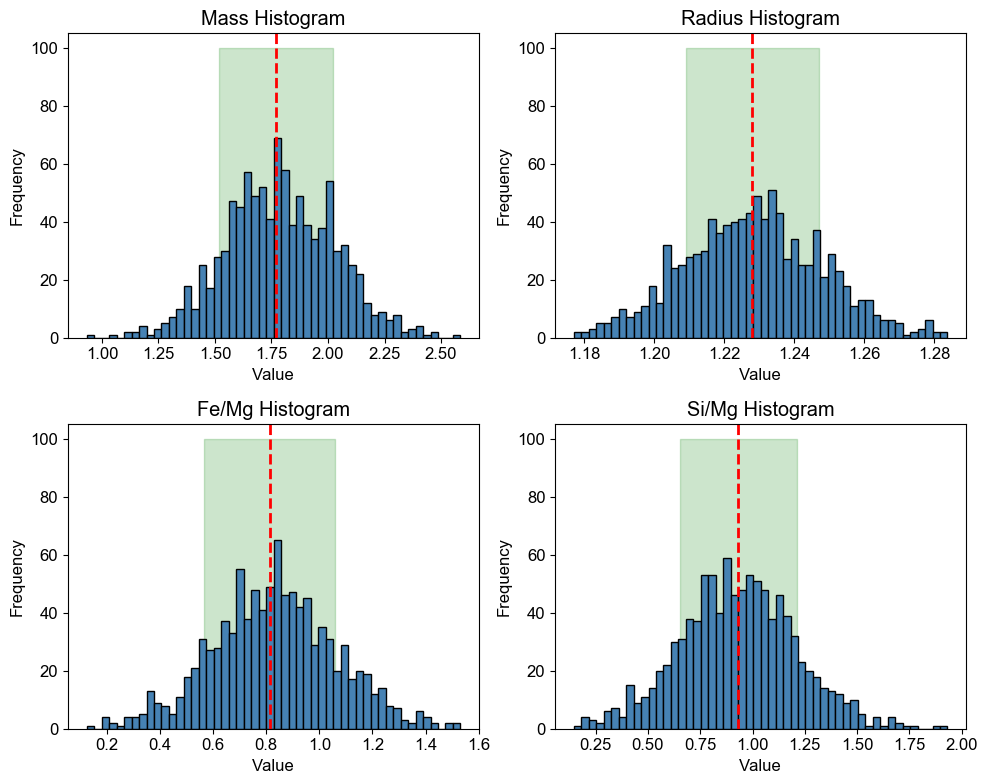

In [3]:
# Set the random seed for reproducibility
np.random.seed(125)

# Define the function to generate samples and plot histogram
def generate_samples_and_plot(mean, err, title, ax):
    """
    Generates Gaussian distributed samples around a mean with a given error,
    and plots a histogram of the samples.
    
    Parameters:
    - mean: The mean value for the Gaussian distribution.
    - err: The standard deviation (error) for the Gaussian distribution.
    - title: The title of the plot.
    - ax: The matplotlib Axes object on which to plot.
    
    Returns:
    - samples: The generated samples.
    """
    samples = np.random.normal(loc=mean, scale=err, size=1000)
    ax.hist(samples, bins=50, color='steelblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # Mark the mean value
    ax.fill_between([mean-err, mean+err], [0, 0], [100, 100], alpha=0.2, color='green')  # Highlight the error range
    return samples

# Create subplots for plotting histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Generate and plot samples for various parameters
mass_samples = generate_samples_and_plot(1.77, 0.25, 'Mass Histogram', axs[0, 0])
radius_samples = generate_samples_and_plot(1.228, 0.019, 'Radius Histogram', axs[0, 1])
femg_samples = generate_samples_and_plot(0.813, 0.248, 'Fe/Mg Histogram', axs[1, 0])
simg_samples = generate_samples_and_plot(0.933, 0.281, 'Si/Mg Histogram', axs[1, 1])

# Combine all samples into an input matrix X
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# Adjust the layout of the subplots
plt.tight_layout()

# Display the histograms
plt.show()


### Step 2: Generate 20,000 plausible interior solutions

For each predicted distribution, we perform 20 samples based on the distribution itself, ensuring that this sampling process accurately reflects the predicted probability distribution of the variables.


In [4]:

# Define the density storage structure for the outputs
density_x = {param: [] for param in output_parameters}
density_y = {param: [] for param in output_parameters}

# Gaussian Sampling
for input_array in X:
    # Transform input for the model prediction
    scaled_input = input_scaler.transform([input_array])
    pred = model.predict(scaled_input)
    
    # Extract the Gaussian mixture parameters
    mus = pred[:, :N_MIXES*OUTPUT_DIMS]
    sigs = pred[:, N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
    pis = mdn.softmax(pred[:, -N_MIXES:])
    
    # Prepare for the sampling
    y_label = np.arange(0, 1, 0.001).reshape(-1, 1)
    
    # Calculate the Gaussian Mixture Model PDF and sample from it
    for i, output_param in enumerate(output_parameters):
        mus_ = mus[0, i::OUTPUT_DIMS]
        sigs_ = sigs[0, i::OUTPUT_DIMS]
        factors = 1 / math.sqrt(2 * math.pi) / sigs_
        exponent = np.exp(-0.5 * ((y_label - mus_) / sigs_)**2)
        GMM_PDF = np.sum(pis[0] * factors * exponent, axis=1)
        
        # Handling edge cases where the GMM PDF is zero to avoid division by zero
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])

# Plot settings for MDN and MCMC results
x_max = [0.15, 1, 1, 0.1, 1, 2500, 6000, 1.5]
x_locator = [0.05, 0.2, 0.2, 0.02, 0.2, 500, 2000, 0.5]
colors = ["steelblue"] * len(output_parameters)


# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))
df_density_y = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_y.items()]))


# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = output_scaler.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)


In [5]:
df_k_samples

,WRF,MRF,CRF,WMF,CMF,CPS,CTP,k2
0,0.144870,0.330812,0.484753,0.0983,0.393526,224.988958,2654.280136,0.621885
1,0.147094,0.331622,0.489478,0.0986,0.321049,237.959917,2665.665304,0.647301
2,0.143980,0.355095,0.509167,0.0996,0.378858,215.723987,2548.018561,0.653655
3,0.144722,0.351048,0.527281,0.0997,0.334854,234.253929,2597.354292,0.661597
4,0.148132,0.382615,0.491841,0.0992,0.376270,217.576981,2658.075192,0.652066
...,...,...,...,...,...,...,...,...
19995,0.103056,0.581732,0.416234,0.0980,0.134677,280.578783,2802.287329,0.830772
19996,0.105280,0.583351,0.334327,0.0995,0.147619,239.812912,2851.623060,0.875250
19997,0.111508,0.572019,0.402058,0.0968,0.127774,247.224888,2768.131823,0.775969
19998,0.117587,0.541261,0.346928,0.0971,0.091535,241.665906,2809.877442,0.818859


### Step 3: Read the MCMC inversion results for Kepler-78 b


In [6]:
# Read MCMC results
df_k = pd.read_csv("mcmc_results/kepler78b_feo.csv")
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

In [7]:
df_k

,mass,FeMg,FeO,SiMg,WMF,radius,CMF,CRF,CPS,CTP,WRF,k2,COP,COT,MRF
0,1.833557,0.756953,0.009369,0.725482,0.022403,1.214157,0.319889,0.512560,243.974887,2931.723707,0.032234,0.800753,681.587951,4221.269640,0.455206
1,1.787753,0.749926,0.098839,0.895968,0.038858,1.225737,0.231911,0.453121,266.585079,2966.490040,0.049546,0.836253,604.338483,3962.020419,0.497334
2,1.822228,0.898007,0.079305,1.002658,0.052031,1.232396,0.268239,0.474991,261.973038,2931.037547,0.063945,0.785225,645.521840,4030.288339,0.461064
3,2.028559,0.922692,0.196387,0.631609,0.020707,1.236602,0.257407,0.478624,305.645945,3101.303972,0.030877,0.854555,723.262192,4209.141389,0.490499
4,1.985086,0.576645,0.134676,0.690293,0.002624,1.240836,0.182764,0.425304,308.391126,3215.964781,0.004666,0.980312,622.497216,4132.490641,0.570030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208027,1.956053,1.074479,0.120604,0.474195,0.040383,1.218468,0.376160,0.546348,253.246336,2867.972881,0.055315,0.736150,784.777866,4273.315865,0.398337
208028,1.742207,0.820732,0.156282,1.031656,0.012667,1.197751,0.197098,0.436289,274.073165,3068.224065,0.019860,0.933235,567.117858,3973.151340,0.543851
208029,1.716235,0.742531,0.001603,1.120234,0.084044,1.241957,0.255446,0.457771,241.957200,2820.665679,0.092128,0.753536,588.005754,3852.589755,0.450101
208030,1.724341,0.937456,0.106038,1.322853,0.079504,1.236499,0.216774,0.435138,262.100650,2883.078829,0.088910,0.785041,572.564630,3793.702011,0.475952


### Step 4: Comparing MCMC and MDN Predictions with Histograms for Kepler-78 b

In this step, we will plot histograms to compare the predictions made by MCMC and MDN models. Mdian values are represented by dashed lines.


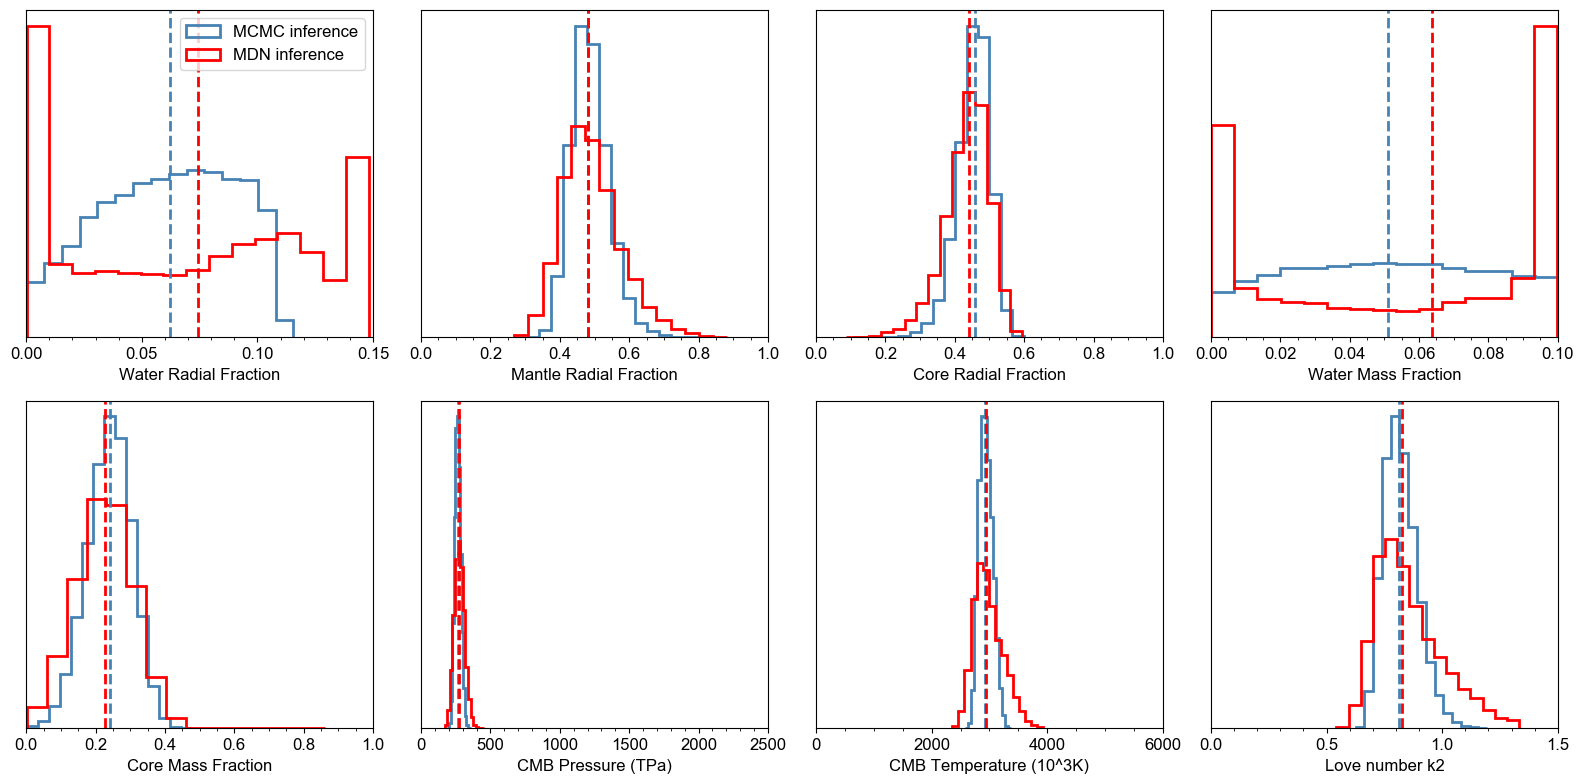

In [8]:
# Plotting comparison histograms for MCMC and MDN results
# Assuming output_parameters, x_max, x_locator are defined as before
# Assuming df_k is the DataFrame containing the MCMC results, loaded as before

x_labels = ['Water Radial Fraction', 'Mantle Radial Fraction', 'Core Radial Fraction', 
            'Water Mass Fraction', 'Core Mass Fraction', 'CMB Pressure (TPa)', 
            'CMB Temperature (10^3K)', 'Love number k2']

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

for i, param in enumerate(output_parameters):
    ax = axs[i]
    # plot MCMC results
    x = df_k[param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='MCMC inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)

    # Set x-axis label from the provided list
    ax.set_xlabel(x_labels[i])

    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    # Add legend to the first subplot
    if i == 0:
        ax.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

# Compare the MCMC and MDN results and calculate the errors
df_k_p = df_k[output_parameters]
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# MDN statistics
mdn_median = np.median(original_x, axis=0)
mdn_lower_err = mdn_median - np.percentile(original_x, 16, axis=0)
mdn_upper_err = np.percentile(original_x, 84, axis=0) - mdn_median

# MCMC statistics
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# Store the results in a DataFrame
results = {
    "Output Parameter": output_parameters,
    "MCMC Median": mcmc_median,
    "MDN Median": mdn_median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": mdn_lower_err,
    "MDN Upper Error": mdn_upper_err
}
df_results = pd.DataFrame(results)

# Optionally, save the results to an Excel file
# df_results.to_excel("Kepler78b_err.xlsx", index=False)